## Google环境配置

导入colab包

In [1]:
from google.colab import drive
import os

挂载Google Drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


切换WorkSpace

In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Anomaly-Detection')

## Global Setting

In [4]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',150)

## 载入数据

Read Data Set

In [5]:
df_train=pd.read_csv('dataset/train_data.csv',encoding="utf-8",header=0)
df_test=pd.read_csv('dataset/test_data.csv',encoding="utf-8",header=0)


In [6]:
test_y = pd.read_csv('dataset/validation_data.csv',encoding="utf-8",header=0)
test_y = test_y['label']

## 数据预处理（Data Preprocessing）

Data Frame Concat

In [7]:
df = pd.concat([df_train,df_test])

Reset Index

In [8]:
df = df.reset_index()

时序数据，转换为标准时间格式

In [9]:
df['start_time']=pd.to_datetime(df['start_time'])

从“start_time”提取时间特征，周日为0，周一为1，...，周六为6

- [pandas.Series.dt.weekday](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.weekday.html#pandas.Series.dt.weekday)

In [10]:
df['weekday']=df['start_time'].dt.weekday

从“start_time”提取时间特征，时

- [pandas.Series.dt.hour](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.hour.html)

In [11]:
df['hour']=df['start_time'].dt.hour

判断是否周末，周末为1，工作日为0



In [12]:
df['weekend']=((df['weekday']==6)|(df['weekday']==0)).astype(int)

判断是否夜间，20点到7点为夜间，夜间为1，白天为0

In [13]:
df['daylight']=((df['hour'] >= 20) | (df['hour'] <= 7)).astype(int)

将value的string数据转为float数据，若转换错误，则设置为空
If ‘coerce’, then invalid parsing will be set as NaN.
- [pandas.to_numeric](https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html)

In [14]:
df['value']=pd.to_numeric(df['value'],errors='coerce')

Fill NA/NaN values using the specified method.

bfill: use next valid observation to fill gap.

- [pandas.Series.fillna](https://pandas.pydata.org/docs/reference/api/pandas.Series.fillna.html)

In [15]:
df['value']=df['value'].fillna(method='bfill')

把ID特征转换为数值型，有限个数据，采用阿拉伯数字编码，考虑采用one-hot生成102维编码

In [16]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['kpi_id']=le.fit_transform(df['kpi'])

正负样本比例数值

In [17]:
pd.crosstab(df.label, "count")

col_0,count
label,
0.0,104258
1.0,1006


正负样本比例柱状图

- Seaborn是基于matplotlib的图形可视化python包。它提供了一种高度交互式界面，便于用户能够做出各种有吸引力的统计图表。Seaborn是在matplotlib的基础上进行了更高级的API封装，从而使得作图更加容易，在大多数情况下使用seaborn能做出很具有吸引力的图，而使用matplotlib就能制作具有更多特色的图。应该把Seaborn视为matplotlib的补充，而不是替代物。同时它能高度兼容numpy与pandas数据结构以及scipy与statsmodels等统计模式。

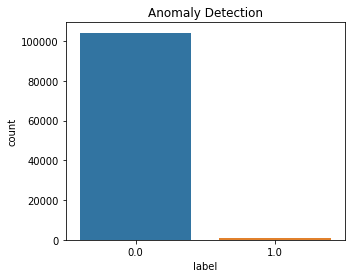

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
fig=plt.figure(figsize=(5,4))
fig=plt.title("Anomaly Detection")
fig=sns.countplot(df.label)

1006个正样本的时间分布柱状图（异常时间点分布）



- [pandas.DataFrame.groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)

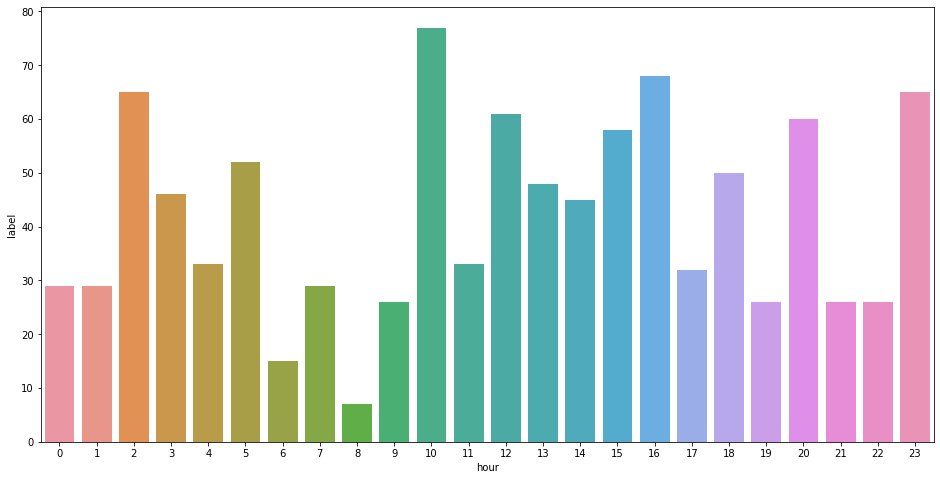

In [19]:
dh = df.groupby('hour')['label'].sum().reset_index()
plt.figure(figsize=(16,8))
sns.barplot(x="hour",y='label', data=dh)
plt.show()

时间序列可视化（部分数据，总共102个关键性能指标）

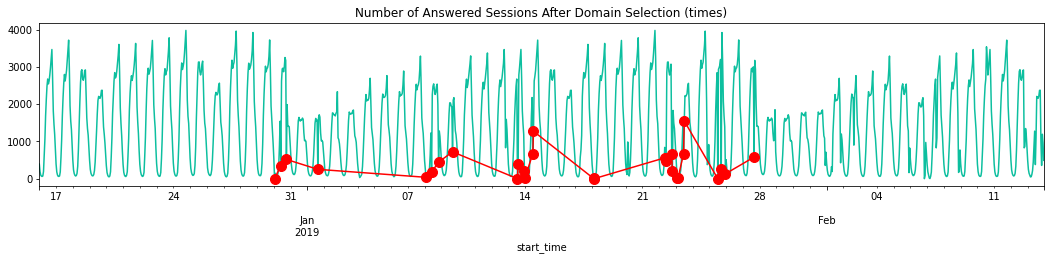

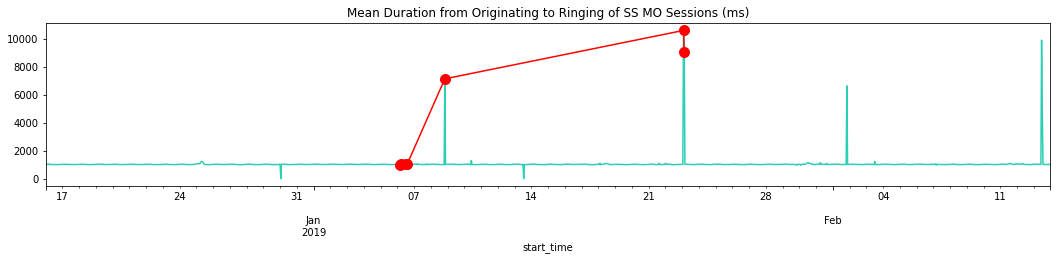

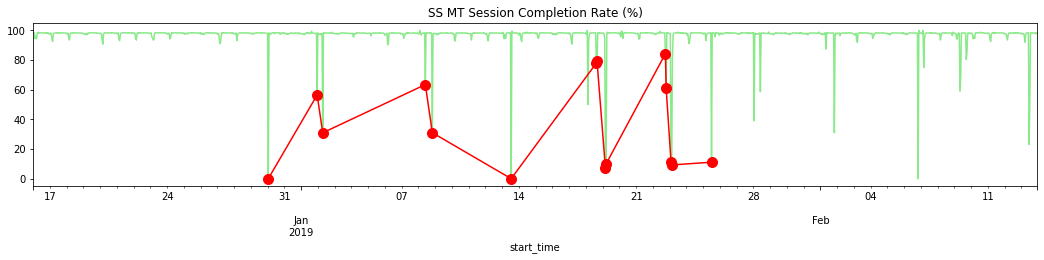

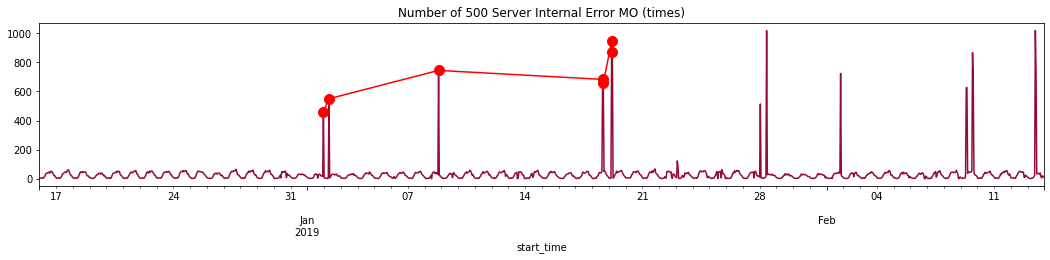

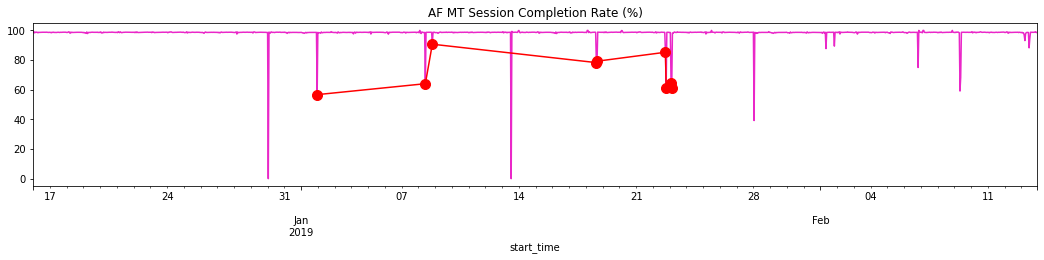

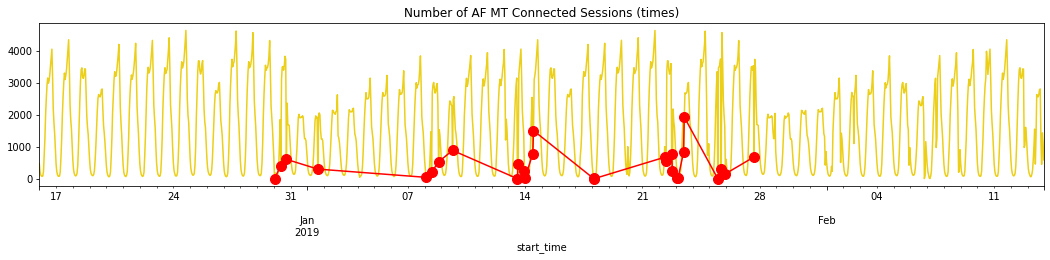

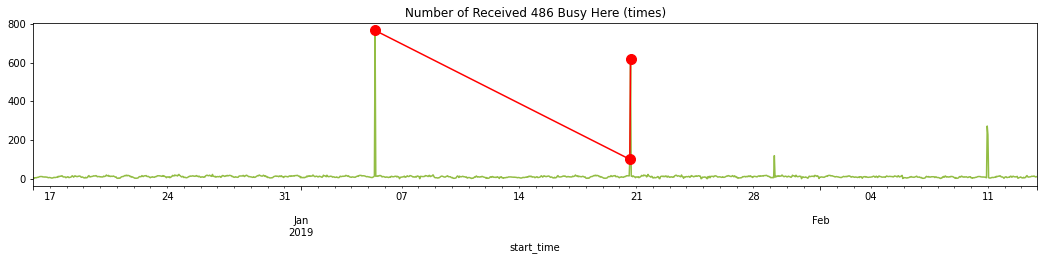

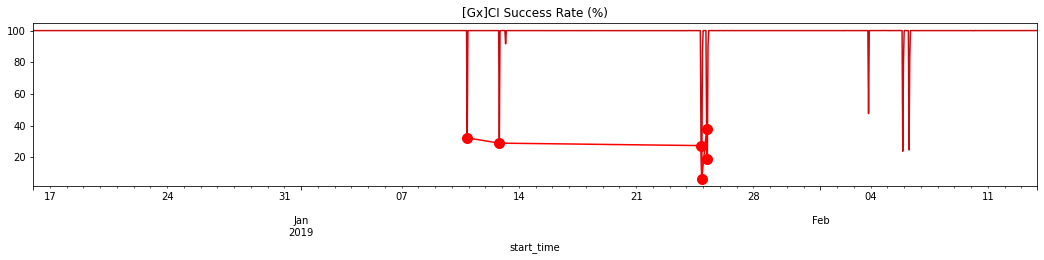

In [20]:
import numpy as np
for i in ['Number of Answered Sessions After Domain Selection (times)',
          'Mean Duration from Originating to Ringing of SS MO Sessions (ms)',
          'SS MT Session Completion Rate (%)',
          'Number of 500 Server Internal Error MO (times)',
          'AF MT Session Completion Rate (%)',
          'Number of AF MT Connected Sessions (times)',
          'Number of Received 486 Busy Here (times)',
          '[Gx]CI Success Rate (%)']:
    dd=df[(df['kpi']==i)]
    dd.sort_values(['start_time'],inplace=True)
    dd.set_index('start_time',inplace=True)
    anomalies=dd[dd['label']==1]
    
    fig=plt.figure(figsize=(18,3))
    fig=dd['value'].rolling(1).mean().plot(c=np.random.rand(3,))
    fig=anomalies['value'].rolling(1).mean().plot(color='red', marker='o',markersize=10)
    fig=plt.title(i)

训练集和测试集数据分布，训练集的正负样本数据分布

以此关键性能指标（KPI）为例，横坐标表示value的值，纵坐标表示频率

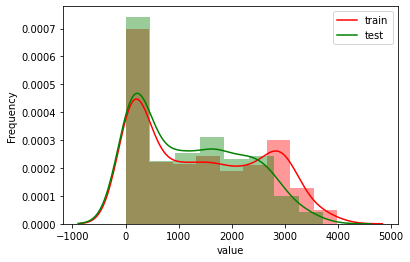

In [21]:
KPI = 'Number of Answered Sessions After Domain Selection (times)'
temp = df[df['kpi']==KPI]
g = sns.distplot(temp['value'][(temp["label"].notnull())],color="Red")
g = sns.distplot(temp['value'][(temp["label"].isnull())],ax=g,color="Green")
g.set_xlabel('value')
g.set_ylabel("Frequency")
g = g.legend(["train","test"])
plt.show()

以此关键性能指标（KPI）为例，横坐标表示value的值，纵坐标表示正负样本的频率

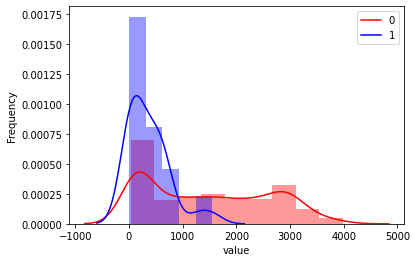

In [22]:
g = sns.distplot(temp['value'][(temp["label"]==0)],color="Red")
g = sns.distplot(temp['value'][(temp["label"]==1)],ax=g,color="Blue")
g.set_xlabel('value')
g.set_ylabel("Frequency")
g = g.legend(["0","1"])
plt.show()

## 特征工程（进一步数据预处理）

根据“kpi_id”和“start_time”排序

In [23]:
df.sort_values(['kpi_id','start_time'],inplace=True)

统计特征，分组滑动窗口（不知道该提取什么特征，参考时序数据特征工程案例）

- rolling: 滑动窗口计算

- mean: Return the mean of the values over the requested axis. (平均值)

- std: Return sample standard deviation over requested axis.

- skew: Return unbiased skew over requested axis.

- kurt: Return unbiased kurtosis over requested axis.

- quantile: Return values at the given quantile over requested axis.

In [24]:
cols = ['value']
for col in cols:
  df['win_2_mean_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=2,min_periods=1).mean().reset_index(0,drop=True)
  df['win_3_mean_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=3,min_periods=2).mean().reset_index(0,drop=True)
  df['win_6_mean_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).mean().reset_index(0,drop=True)
  df['win_6_std_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).std().reset_index(0,drop=True)
  df['win_6_skew_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).skew().reset_index(0,drop=True)
  df['win_6_kurt_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).kurt().reset_index(0,drop=True)
  df['win_6_q25_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).quantile(0.25).reset_index(0,drop=True)
  df['win_6_q50_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).quantile(0.50).reset_index(0,drop=True)
  df['win_6_q75_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).quantile(0.75).reset_index(0,drop=True)
  df['win_12_mean_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).mean().reset_index(0,drop=True)
  df['win_12_std_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).std().reset_index(0,drop=True)
  df['win_12_skew_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).skew().reset_index(0,drop=True)
  df['win_12_kurt_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).kurt().reset_index(0,drop=True)
  df['win_12_q25_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).quantile(0.25).reset_index(0,drop=True)
  df['win_12_q50_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).quantile(0.50).reset_index(0,drop=True)
  df['win_12_q75_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).quantile(0.75).reset_index(0,drop=True)

趋势特征和周期特征

In [25]:
df['expa_mean']=df.groupby(["kpi_id"])['value'].expanding().mean().reset_index(drop=True)
df['expa_std']=df.groupby(["kpi_id"])['value'].expanding().std().reset_index(drop=True)
df['win_3_mean']= df.groupby("kpi_id")['value'].rolling(window=3,min_periods=3).mean().reset_index(0,drop=True)
df['trend_win3']=df['value']-df['win_3_mean']
df['z_score']=(df['win_3_mean']-(df.groupby("kpi_id")['value'].transform('mean')))/df.groupby("kpi_id")['value'].transform('std')

In [26]:
train=df[df['label'].notnull()]

In [27]:
test=df[df['label'].isnull()]

In [28]:
train.fillna(0,inplace=True)
test.fillna(0,inplace=True)

In [29]:
test.sort_values('index',inplace=True)

In [30]:
train.drop(['start_time','index','kpi'],axis=1,inplace=True)

In [31]:
test.drop(['start_time','index','label','kpi'],axis=1,inplace=True)

将数据中非数字符号转为数字符号

In [32]:
train[:] = np.nan_to_num(train)
test[:] = np.nan_to_num(test)

生成“train_x”和“train_y”
> axis=0 表示删除行， axis=1 表示删除列

In [33]:
train_y = train['label']
train_x = train.drop('label',axis=1)

In [34]:
test_x=test.reset_index(drop=True)

## 数据采样

If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.

In [35]:
import torch
import torch.nn as nn
if torch.cuda.is_available():
    device = torch.device("cuda")
    !nvidia-smi
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

Tue Jun  1 11:44:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

采用了SMOTE的变体SMOTENC对数据做过采样

In [36]:
from imblearn.over_sampling import SMOTENC

In [37]:
smo = SMOTENC(random_state=42,categorical_features=[1,2,3,4,5])

采样时间大概3~5分钟，测试模型时注释

In [38]:
x_smo, y_smo = smo.fit_sample(train_x,train_y)
train_x = pd.DataFrame(x_smo).reset_index(drop=True)
train_y = pd.DataFrame(y_smo).reset_index(drop=True)

PyTorch 数据格式转换

In [39]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [40]:
train_data = TensorDataset(torch.from_numpy(np.array(train_x)), torch.from_numpy(np.array(train_y)))

In [41]:
valid_data = TensorDataset(torch.from_numpy(np.array(test_x)), torch.from_numpy(np.array(test_y)))

## 超参设置

In [42]:
batch_size = 20
hidden_size = 256
LR = 0.00001
EPOCH = 30
num_layers = 2

## 建模（LSTM）

In [43]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [44]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

In [45]:
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample output size: ', sample_y.size()) # batch_size, seq_length

Sample input size:  torch.Size([20, 28])
Sample output size:  torch.Size([20, 1])


In [46]:
class LSTM(nn.Module):
    def __init__(self,hidden_size,num_layers):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers, 
            batch_first=True)
        self.out = nn.Sequential(nn.Linear(hidden_size,1))
    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)   # None 表示 hidden state 会用全 0 的 state
        return self.out(r_out[:, -1, :])

In [47]:
model = LSTM(hidden_size,num_layers)
model.to(device)

LSTM(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True)
  (out): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # optimize all cnn parameters
loss_func = nn.MSELoss()

## 训练

In [49]:
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [50]:
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]
valid_loss_min = np.Inf

In [51]:
for step in range(EPOCH):
  train_losses = []
  train_acc = 0.0
  model.train()
  for tx, ty in train_loader:      
    tx=tx.float()
    ty=ty.float()
    tx, ty = tx.to(device), ty.to(device)
    output = model(torch.unsqueeze(tx, dim=2))
    loss = loss_func(torch.squeeze(output), ty)
    optimizer.zero_grad()  # clear gradients for this training step
    loss.backward()  # back propagation, compute gradients
    optimizer.step()
    train_losses.append(loss.item())
    # calculating accuracy
    accuracy = acc(output,ty)
    train_acc += accuracy
  val_losses = []
  val_acc = 0.0
  model.eval()
  for tx, ty in valid_loader:
    tx=tx.float()
    ty=ty.float()
    tx, ty = tx.to(device), ty.to(device)
    output = model(torch.unsqueeze(tx, dim=2))
    val_loss = loss_func(torch.squeeze(output), ty)
    val_losses.append(val_loss.item())
    accuracy = acc(output,ty)
    val_acc += accuracy
  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)
  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(valid_loader.dataset)
  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)
  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)
  print(f'Epoch {step+1}') 
  print(f'Train Loss : {epoch_train_loss} Val Loss : {epoch_val_loss}')
  print(f'Train Accuracy : {epoch_train_acc*100} Val Accuracy : {epoch_val_acc*100}')
  if epoch_val_loss <= valid_loss_min:
    torch.save(model, 'model.pkl')
    print('Validation Loss Decreased ({:.6f} --> {:.6f}).  Saving Model ...'.format(valid_loss_min,epoch_val_loss))
    valid_loss_min = epoch_val_loss
  print(35*'==')

Epoch 1
Train Loss : 0.2524400023751014 Val Loss : 0.2561677733918671
Train Accuracy : 70.1706343877688 Val Accuracy : 39.24211841599385
Validation Loss Decreased (inf --> 0.256168).  Saving Model ...
Epoch 2
Train Loss : 0.24985740125556608 Val Loss : 0.22671113954834615
Train Accuracy : 78.00072896084713 Val Accuracy : 93.28863898500576
Validation Loss Decreased (0.256168 --> 0.226711).  Saving Model ...
Epoch 3
Train Loss : 0.24983501930126364 Val Loss : 0.22310428011308547
Train Accuracy : 79.78764219532314 Val Accuracy : 94.8961937716263
Validation Loss Decreased (0.226711 --> 0.223104).  Saving Model ...
Epoch 4
Train Loss : 0.2498186313969353 Val Loss : 0.2413390640353767
Train Accuracy : 82.16060158453068 Val Accuracy : 80.5363321799308
Epoch 5
Train Loss : 0.24976805204933994 Val Loss : 0.22406544513080281
Train Accuracy : 81.72850045080473 Val Accuracy : 95.19896193771626
Epoch 6
Train Loss : 0.24975729483018425 Val Loss : 0.23330568369336566
Train Accuracy : 81.9610965105795

## 训练数据可视化

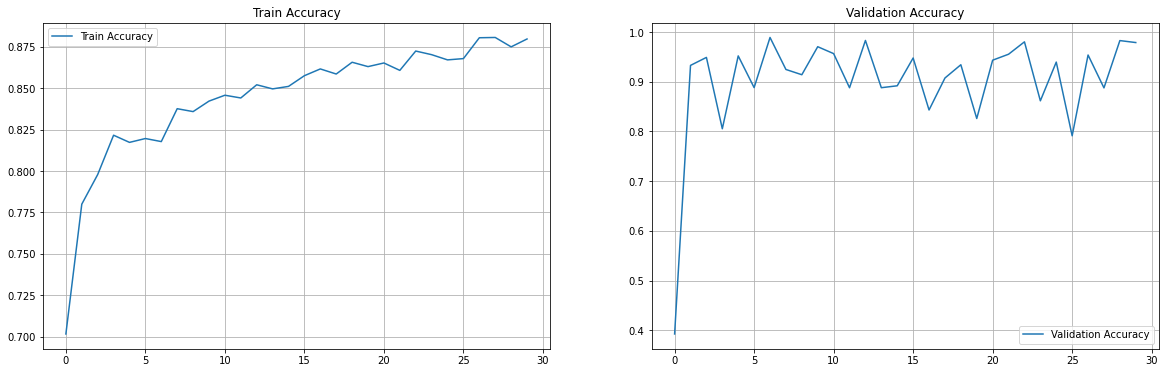

In [78]:
fig = plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Accuracy')
plt.title("Train Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_vl_acc, label='Validation Accuracy')
plt.title("Validation Accuracy")
plt.legend()
plt.grid()

plt.show()

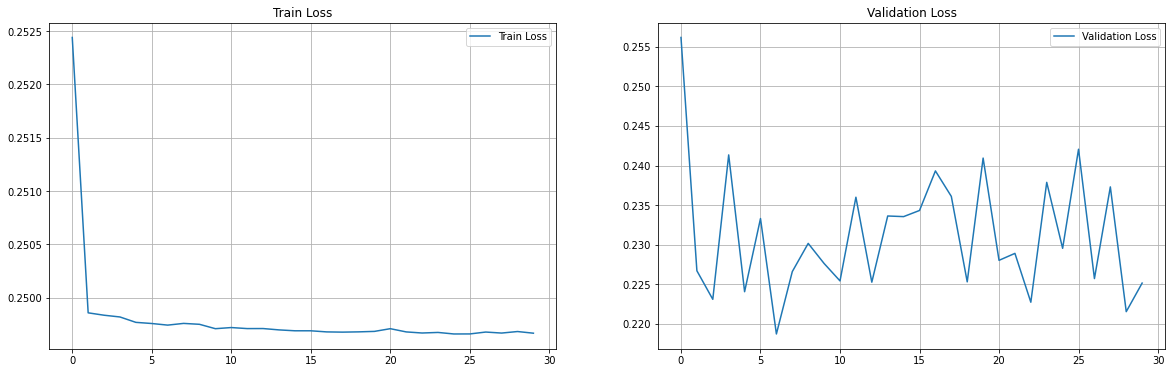

In [79]:
fig = plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_tr_loss, label='Train Loss')
plt.title("Train Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_vl_loss, label='Validation Loss')
plt.title("Validation Loss")
plt.legend()
plt.grid()

plt.show()

## 预测（Inferance）

In [53]:
def predict(tx):
  tx = tx.float()
  tx = tx.to(device)
  output = model(torch.unsqueeze(tx, dim=2))
  return(output.item())

In [54]:
test_pre = df_test

通过test_x计算label，写入test_pred_prob，最后加入test_pre

In [56]:
test_x = TensorDataset(torch.from_numpy(np.array(test_x)))

In [82]:
test_pred_prob = []

In [83]:
for input in test_x:
  test_pred_prob.append(predict(input[0].reshape(1,-1)))

In [87]:
test_pred_prob = np.array(test_pred_prob)

循环test_x生成张量，通过模型计算结果。

In [95]:
test_pre['pre_label']=test_pred_prob

In [96]:
test_pre.head()

,0,start_time,value,kpi,label,pre_label
0,1,2019/1/28 0:00,794,Number of Answered Sessions After Domain Selec...,0,0.485716
1,2,2019/1/28 1:00,400,Number of Answered Sessions After Domain Selec...,0,0.492348
2,3,2019/1/28 2:00,247,Number of Answered Sessions After Domain Selec...,0,0.492414
3,4,2019/1/28 3:00,156,Number of Answered Sessions After Domain Selec...,0,0.491122
4,5,2019/1/28 4:00,120,Number of Answered Sessions After Domain Selec...,0,0.479729


## 召回

In [182]:
test_pre['label']=test_pre.apply(lambda row : 1 if row['pre_label'] >=0.505 else 0,axis=1)
sub=test_pre[['start_time','kpi','label']]
sub['label'].sum()

594

正负Result比例数值

In [183]:
pd.crosstab(sub.label, "count")

col_0,count
label,
0,41022
1,594


正负Result比例柱状图

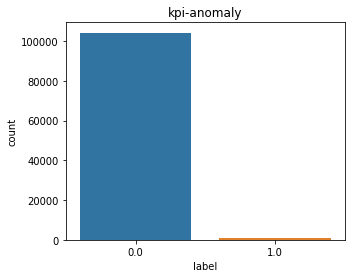

In [184]:
fig=plt.figure(figsize=(5,4))
fig=sns.countplot(df.label)
fig=plt.title("kpi-anomaly")

In [185]:
sub.to_csv('Result.csv', encoding="utf_8_sig", index=False)

## 评分


> 评价指标：

> 11 TP(True Positive): 真实为 1，预测也为 1

> 10 FN(False Negative): 真实为 1，预测为 0

> 01 FP(False Positive): 真实为 0，预测为 1

> 00 TN(True Negative): 真实为 0，预测也为 0

> 按以下公式计算成绩评分，依据准确率（公式 1）和召回率（公式 2），计算 F1-score（公式 3）

> P = TP/(TP+FP)（公式 1）

> R = TP/(TP+FN)（公式 2）

> F1-score = 2*P*R/（P+R）（公式 3）

In [186]:
import pandas as pd
Result = pd.read_csv('Result.csv', encoding='utf-8')
Target = pd.read_csv('dataset/validation_data.csv', encoding='utf-8')
label = pd.DataFrame()
label['real'] = Target['label']
label['predictive'] = Result['label']
label = label.applymap(str)
label['label'] = label['real']+label['predictive']
TP = len(label[label['label']=='11'])
FN = len(label[label['label']=='10'])
FP = len(label[label['label']=='01'])
TN = len(label[label['label']=='00'])
P = TP/(TP+FP)
R = TP/(TP+FN)
Score = 2*P*R/(P+R)
print(Score)

0.7156756756756757
